***Wake Word Detection is the perfect application of TinyML. We can train a tiny model that listens for a wake word, run it on a low powered chip. If we embed this in a phone , it can listen for wake words all the time. When it hears the wake word, it informs the phone's operating system, which can begin to capture the audio & send it to the server. So, a tiny efficient model "wakes up" a larger, more resource hungry model.***

**Building the TensorFlow Model:** \\
**For Wake Word Detection, the four classes has been considered for detection which includes: yes, no, silence & unknown words.**

In [ ]:
# Words to be recognized are added & separated by commas
WANTED_WORDS = "yes,no"

# lists to define the rate at each stage. For example,
# will run 12,000 training loops in total, with a rate of 0.001 and 0.0001 for the final 3,000.
TRAINING_STEPS = "12000,3000"
LEARNING_RATE = "0.001,0.0001"

# Calculate the total number of steps, which is used to identify the checkpoint
# file name.
TOTAL_STEPS = str(sum(map(lambda string: int(string), TRAINING_STEPS.split(","))))

# Print the configuration to confirm it
print("Training these words: %s" % WANTED_WORDS)
print("Training steps in each stage: %s" % TRAINING_STEPS)
print("Learning rate in each stage: %s" % LEARNING_RATE)
print("Total number of training steps: %s" % TOTAL_STEPS)

Training these words: yes,no
Training steps in each stage: 12000,3000
Learning rate in each stage: 0.001,0.0001
Total number of training steps: 15000


In [ ]:
# Calculate the percentage of 'silence' and 'unknown' training samples required
# to ensure that we have equal number of samples for each label.
number_of_labels = WANTED_WORDS.count(',') + 1
number_of_total_labels = number_of_labels + 2 # for 'silence' and 'unknown' label
equal_percentage_of_training_samples = int(100.0/(number_of_total_labels))
SILENT_PERCENTAGE = equal_percentage_of_training_samples
UNKNOWN_PERCENTAGE = equal_percentage_of_training_samples

# Constants which are shared during training and inference 
PREPROCESS = 'micro'
WINDOW_STRIDE = 20
MODEL_ARCHITECTURE = 'tiny_conv' 
# Other options include: single_fc, conv, low_latency_conv, low_latency_svdf, tiny_embedding_conv

# Constants used during training only
VERBOSITY = 'WARN'
EVAL_STEP_INTERVAL = '1000'
SAVE_STEP_INTERVAL = '1000'

# Constants for training directories and filepaths
DATASET_DIR =  'dataset/'
LOGS_DIR = 'logs/'
TRAIN_DIR = 'train/' # for training checkpoints and other files.

# Constants for inference directories and filepaths
import os
MODELS_DIR = 'models'
if not os.path.exists(MODELS_DIR):
  os.mkdir(MODELS_DIR)
MODEL_TF = os.path.join(MODELS_DIR, 'model.pb')
MODEL_TFLITE = os.path.join(MODELS_DIR, 'model.tflite')
FLOAT_MODEL_TFLITE = os.path.join(MODELS_DIR, 'float_model.tflite')
MODEL_TFLITE_MICRO = os.path.join(MODELS_DIR, 'model.cc')
SAVED_MODEL = os.path.join(MODELS_DIR, 'saved_model')

QUANT_INPUT_MIN = 0.0
QUANT_INPUT_MAX = 26.0
QUANT_INPUT_RANGE = QUANT_INPUT_MAX - QUANT_INPUT_MIN

**Install Dependencies**

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

TensorFlow 1.x selected.


**DELETE any old data from previous runs**

In [ ]:
!rm -rf {DATASET_DIR} {LOGS_DIR} {TRAIN_DIR} {MODELS_DIR}

**Clone the TensorFlow Github Repository, which contains the relevant code required to run this tutorial.**

In [ ]:
!git clone -q --depth 1 https://github.com/tensorflow/tensorflow

**The following script downloads the dataset and begin training.**

In [ ]:
!python tensorflow/tensorflow/examples/speech_commands/train.py \
--data_dir={DATASET_DIR} \
--wanted_words={WANTED_WORDS} \
--silence_percentage={SILENT_PERCENTAGE} \
--unknown_percentage={UNKNOWN_PERCENTAGE} \
--preprocess={PREPROCESS} \
--window_stride={WINDOW_STRIDE} \
--model_architecture={MODEL_ARCHITECTURE} \
--how_many_training_steps={TRAINING_STEPS} \
--learning_rate={LEARNING_RATE} \
--train_dir={TRAIN_DIR} \
--summaries_dir={LOGS_DIR} \
--verbosity={VERBOSITY} \
--eval_step_interval={EVAL_STEP_INTERVAL} \
--save_step_interval={SAVE_STEP_INTERVAL}

2021-07-01 13:16:10.746760: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-07-01 13:16:10.747084: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556c83252a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-01 13:16:10.747119: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-07-01 13:16:10.751703: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-01 13:16:11.083399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-01 13:16:11.084107: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556c83253b80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-07-0

**Combine relevant training results (graph, weights, etc) into a single file for inference. This process is known as freezing a model and the resulting model is known as a frozen model/graph, as it cannot be further re-trained after this process.**

In [ ]:
!rm -rf {SAVED_MODEL}
!python tensorflow/tensorflow/examples/speech_commands/freeze.py \
--wanted_words=$WANTED_WORDS \
--window_stride_ms=$WINDOW_STRIDE \
--preprocess=$PREPROCESS \
--model_architecture=$MODEL_ARCHITECTURE \
--start_checkpoint=$TRAIN_DIR$MODEL_ARCHITECTURE'.ckpt-'{TOTAL_STEPS} \
--save_format=saved_model \
--output_file={SAVED_MODEL}

2021-07-01 14:46:09.770424: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2199995000 Hz
2021-07-01 14:46:09.770654: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e12954ca00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-07-01 14:46:09.770687: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2021-07-01 14:46:09.773995: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2021-07-01 14:46:10.002768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:983] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-01 14:46:10.003552: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55e12954db80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-07-0

**Preparing the testing data for the testing of tflite model**

In [ ]:
import sys
# We add this path so we can import the speech processing modules.
sys.path.append("/content/tensorflow/tensorflow/examples/speech_commands/")
import input_data
import models
import numpy as np

In [ ]:
SAMPLE_RATE = 16000
CLIP_DURATION_MS = 1000
WINDOW_SIZE_MS = 30.0
FEATURE_BIN_COUNT = 40
BACKGROUND_FREQUENCY = 0.8
BACKGROUND_VOLUME_RANGE = 0.1
TIME_SHIFT_MS = 100.0

DATA_URL = 'https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz'
VALIDATION_PERCENTAGE = 10
TESTING_PERCENTAGE = 10

In [ ]:
model_settings = models.prepare_model_settings(
    len(input_data.prepare_words_list(WANTED_WORDS.split(','))),
    SAMPLE_RATE, CLIP_DURATION_MS, WINDOW_SIZE_MS,
    WINDOW_STRIDE, FEATURE_BIN_COUNT, PREPROCESS)
audio_processor = input_data.AudioProcessor(
    DATA_URL, DATASET_DIR,
    SILENT_PERCENTAGE, UNKNOWN_PERCENTAGE,
    WANTED_WORDS.split(','), VALIDATION_PERCENTAGE,
    TESTING_PERCENTAGE, model_settings, LOGS_DIR)

**Converting the model into Float TFLite model & Quantized TFLite model with representative dataset**

In [ ]:
with tf.Session() as sess:
  float_converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  float_tflite_model = float_converter.convert()
  float_tflite_model_size = open(FLOAT_MODEL_TFLITE, "wb").write(float_tflite_model)
  print("Float model is %d bytes" % float_tflite_model_size)

  converter = tf.lite.TFLiteConverter.from_saved_model(SAVED_MODEL)
  converter.optimizations = [tf.lite.Optimize.DEFAULT]
  converter.inference_input_type = tf.lite.constants.INT8
  converter.inference_output_type = tf.lite.constants.INT8
  def representative_dataset_gen():
    for i in range(100):
      data, _ = audio_processor.get_data(1, i*1, model_settings,
                                         BACKGROUND_FREQUENCY, 
                                         BACKGROUND_VOLUME_RANGE,
                                         TIME_SHIFT_MS,
                                         'testing',
                                         sess)
      flattened_data = np.array(data.flatten(), dtype=np.float32).reshape(1, 1960)
      yield [flattened_data]
  converter.representative_dataset = representative_dataset_gen
  tflite_model = converter.convert()
  tflite_model_size = open(MODEL_TFLITE, "wb").write(tflite_model)
  print("Quantized model is %d bytes" % tflite_model_size)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from models/saved_model/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: input
INFO:tensorflow: tensor name: Reshape_1:0, shape: (1, 1960), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: output
INFO:tensorflow: tensor name: labels_softmax:0, shape: (1, 4), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from models/saved_model/variables/variables
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating

**Invoking the interpreter & doing the prediction of processed audio signal**

In [ ]:
# Helper function to run inference
def run_tflite_inference(tflite_model_path, model_type="Float"):
  # Load test data
  np.random.seed(0) # set random seed for reproducible test results.
  with tf.Session() as sess:
    test_data, test_labels = audio_processor.get_data(
        -1, 0, model_settings, BACKGROUND_FREQUENCY, BACKGROUND_VOLUME_RANGE,
        TIME_SHIFT_MS, 'testing', sess)
  test_data = np.expand_dims(test_data, axis=1).astype(np.float32)

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(tflite_model_path)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # For quantized models, manually quantize the input data from float to integer
  if model_type == "Quantized":
    input_scale, input_zero_point = input_details["quantization"]
    test_data = test_data / input_scale + input_zero_point
    test_data = test_data.astype(input_details["dtype"])

  correct_predictions = 0
  for i in range(len(test_data)):
    interpreter.set_tensor(input_details["index"], test_data[i])
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    top_prediction = output.argmax()
    correct_predictions += (top_prediction == test_labels[i])

  print('%s model accuracy is %f%% (Number of test samples=%d)' % (
      model_type, (correct_predictions * 100) / len(test_data), len(test_data)))

In [ ]:
# Compute float model accuracy
run_tflite_inference(FLOAT_MODEL_TFLITE)

# Compute quantized model accuracy
run_tflite_inference(MODEL_TFLITE, model_type='Quantized')

Float model accuracy is 91.828479% (Number of test samples=1236)
Quantized model accuracy is 91.828479% (Number of test samples=1236)


**Converting the TFLite version of model into C type array** 

In [ ]:
# Install xxd if it is not available
!apt-get update && apt-get -qq install xxd
# Convert to a C source file
!xxd -i {MODEL_TFLITE} > {MODEL_TFLITE_MICRO}
# Update variable names
REPLACE_TEXT = MODEL_TFLITE.replace('/', '_').replace('.', '_')
!sed -i 's/'{REPLACE_TEXT}'/g_model/g' {MODEL_TFLITE_MICRO}

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

**C array of TFLite model**

In [ ]:
# Print the C source file
!cat {MODEL_TFLITE_MICRO}

unsigned char g_model[] = {
  0x20, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x00, 0x00,
  0x00, 0x00, 0x12, 0x00, 0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x10, 0x00, 0x14, 0x00, 0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00,
  0x03, 0x00, 0x00, 0x00, 0x94, 0x48, 0x00, 0x00, 0x34, 0x42, 0x00, 0x00,
  0x1c, 0x42, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00,
  0x01, 0x00, 0x00, 0x00, 0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00,
  0x04, 0x00, 0x08, 0x00, 0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00,
  0x0b, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x0c, 0x00, 0x00, 0x00, 0xd4, 0x41, 0x00, 0x00,
  0xb4, 0x41, 0x00, 0x00, 0x24, 0x03, 0x00, 0x00, 0xf4, 0x02, 0x00, 0x00,
  0xec, 0x02, 0x00, 0x00, 0xe4, 0x02, 0x00, 0x00, 0xc4, 0x02, 0x00, 0x00,
  0xbc, 0x02, 0x00, 0x00, 0x2c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00,
  0x1c, 0x

**Steps to be followed for loading the model:**


1.   Extract the C file of TFLite model from the Google Colab
2.   Update the C array of model & labels in the following files:


*   Model Update: **tensorflow/lite/micro/examples/micro_speech/micro_features/model.cc**
*   Label Update: **tensorflow/lite/micro/examples/micro_speech/micro_features/micro_model_settings.cc** 











**In microcontroller, "main_function.cc" file has to be loaded which is the key part for running this application on embedded device.** 

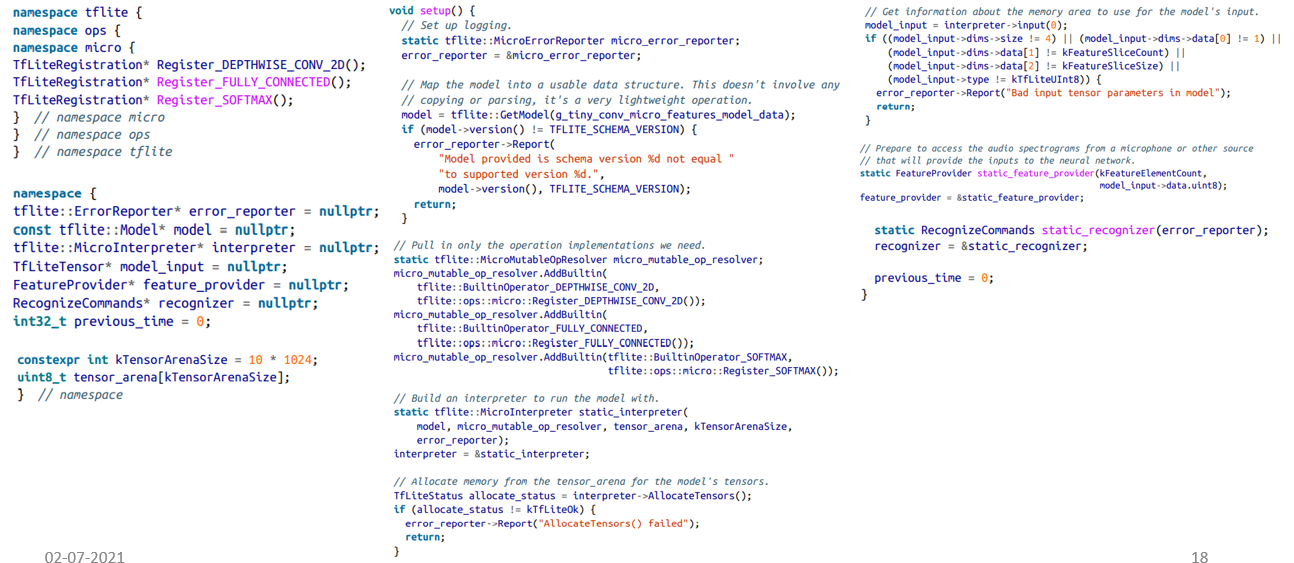

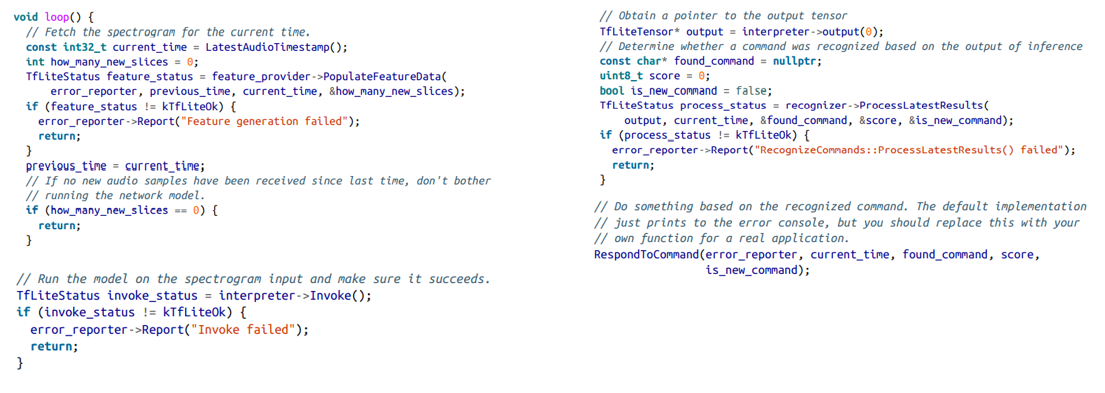

**Implementation in Arduino Nano 33 BLE Sense:   \\
Click "micro_speech" to load the example in Arduino IDE. It will appear as a new window, with a tab for each of the source files. The file in first tab , micro_speech is equivalent to main_function.cc.** 

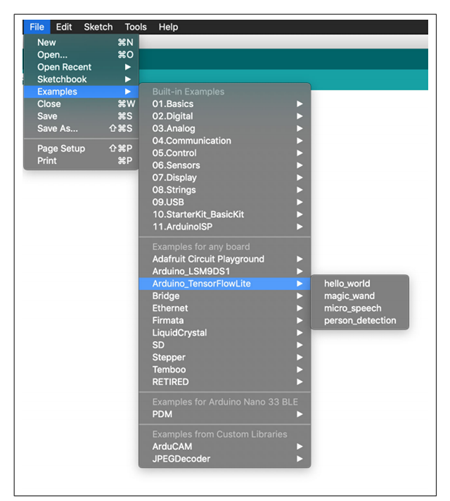

**Based on the microcontroller used for the implementation, it is necessary to update the command_responder.cc**

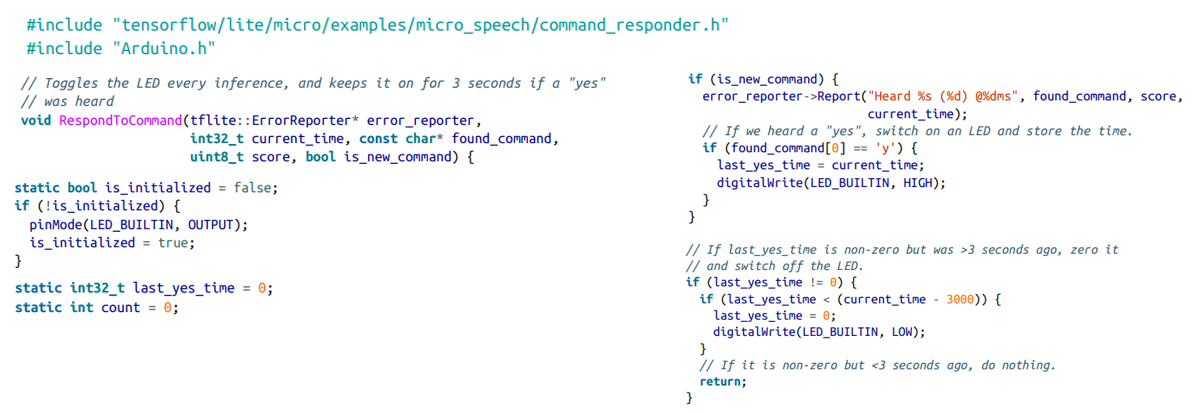